In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import gokart
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression

pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import japanize_matplotlib
import seaborn as sns
sns.set(font='IPAexGothic')

In [25]:
import shap

In [2]:
data = pd.read_csv("./data/train.csv")

In [7]:
data["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [55]:
preprocessed_data = data.copy()
preprocessed_data["Pclass"] = preprocessed_data["Pclass"].astype("category")
preprocessed_data["Sex"] = preprocessed_data["Sex"].replace({"male":0, "female":1})
preprocessed_data["Embarked"] = preprocessed_data["Embarked"].fillna("Nan").replace({'S':0, 'C':1, 'Q':2, "Nan":3}).astype("category")

feature_columns = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Embarked"]
target_column = "Survived"
feature_data = preprocessed_data[feature_columns]
target_data = preprocessed_data[target_column]


# lightgbm

In [56]:
import lightgbm

In [186]:
train_set = lightgbm.Dataset(data=feature_data, label=target_data)
params = dict(objective="binary")
booster = lightgbm.train(train_set=train_set, params=params)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [187]:
explainer = shap.TreeExplainer(booster, data=feature_data)

In [188]:
# 各特徴がどれだけ寄与したかを示す
shap_values = explainer.shap_values(feature_data)

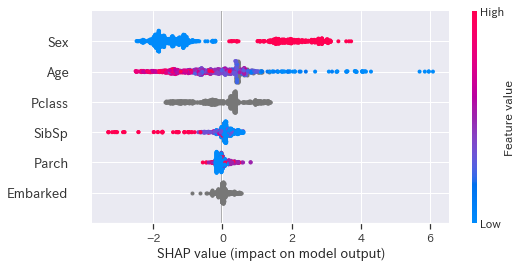

In [189]:
# shap valueのsummary
shap.summary_plot(
    shap_values=shap_values,
    features=feature_data,
    feature_names=feature_data.columns)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


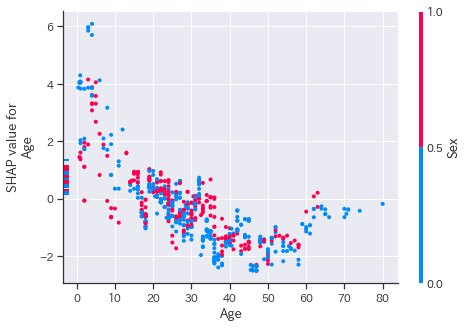

In [190]:
# Dependence Plot
# 取りうる値と SHAP Value の関係
# summary plot の 色と横軸の関係を縦横にプロット

shap.dependence_plot(ind='Age',
                     interaction_index='Sex', # 色に別軸を設定できる
                     shap_values=shap_values,
                     features=feature_data,
                     feature_names=feature_data.columns)

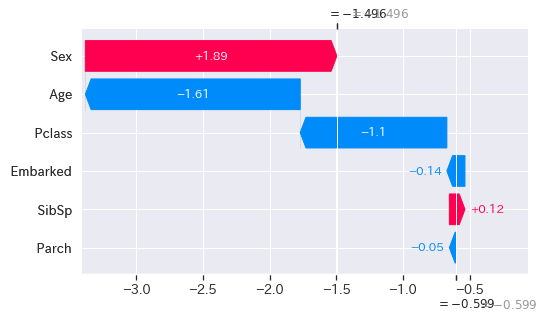

In [191]:
# Waterfall Plot: shap.plots._waterfall.waterfall_legacy() を使うことに注意
# 各予測に対して、どの特徴がどういう寄与をしたかを示す

person_index = 11
shap.plots._waterfall.waterfall_legacy(expected_value=explainer.expected_value,
                    shap_values=shap_values[person_index],
                    features=feature_data.iloc[person_index],
                    feature_names=feature_data.columns)

In [192]:
explainer.expected_value

-0.5991553018149401

In [193]:
shap_values

array([[ 0.23903982, -1.80904732,  0.19496606,  0.14485102, -0.16783771,
         0.03661159],
       [-1.17890222,  2.16541559, -1.37022242,  0.21161855, -0.1979249 ,
         0.2180064 ],
       [ 0.58509841,  2.06897034, -0.61931834,  0.59246283, -0.039918  ,
        -0.11308137],
       ...,
       [ 1.29714879,  2.48266223,  0.7885881 ,  0.18648321, -0.23718032,
        -0.02470138],
       [-0.51245518, -1.28693836, -0.01956323,  0.52064565,  0.05720272,
         0.19708252],
       [ 0.33711393, -1.80703776,  0.73345738,  0.22612567,  0.100356  ,
        -0.21629649]])

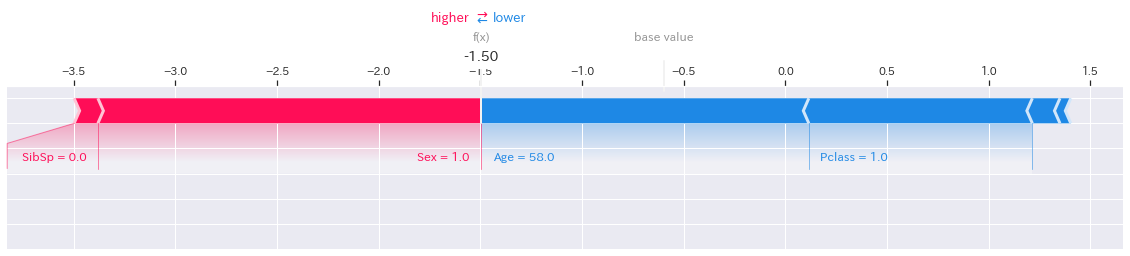

In [198]:
# force plot: waterfallと同様
person_index = 11

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values[person_index,:], 
    features=feature_data.iloc[person_index,:],
    matplotlib=True
)

# pytorch

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim

In [163]:
model = nn.Sequential()
model.add_module('fc1', nn.Linear(6,10))
model.add_module('relu', nn.ReLU())
model.add_module('fc2', nn.Linear(10,10))
model.add_module('relu', nn.ReLU())
model.add_module('fc3', nn.Linear(10,1))
model.add_module('sigmoid', nn.Sigmoid())

In [164]:
model

Sequential(
  (fc1): Linear(in_features=6, out_features=10, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [165]:
feature_data

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,0,22.0,1,0,0
1,1,1,38.0,1,0,1
2,3,1,26.0,0,0,0
3,1,1,35.0,1,0,0
4,3,0,35.0,0,0,0
...,...,...,...,...,...,...
886,2,0,27.0,0,0,0
887,1,1,19.0,0,0,0
888,3,1,NaN,1,2,0
889,1,0,26.0,0,0,1


In [179]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.BCELoss()

input_tensor = torch.tensor(feature_data.astype(np.float32).fillna(0).astype(np.float32).values)
target_tensor = torch.tensor(target_data.astype(np.float32).values.reshape([-1,1]))

model.train()
for i in range(1000):
    predict = model(input_tensor)
    loss = criterion(predict, target_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [180]:
deep_explainer = shap.DeepExplainer(model, data=input_tensor)

In [181]:
# 各特徴がどれだけ寄与したかを示す
deep_shap_values = deep_explainer.shap_values(input_tensor)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


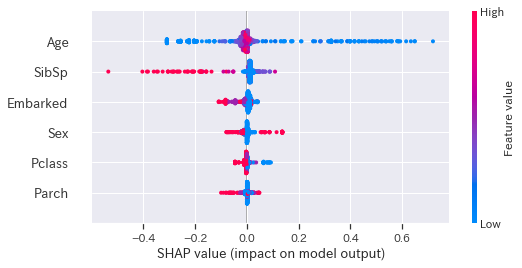

In [182]:
# shap valueのsummary
shap.summary_plot(
    shap_values=deep_shap_values,
    features=input_tensor,
    feature_names=feature_data.columns)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


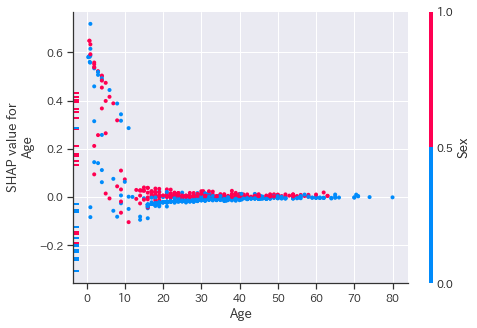

In [183]:
# Dependence Plot
# 取りうる値と SHAP Value の関係
# summary plot の 色と横軸の関係を縦横にプロット

shap.dependence_plot(ind='Age',
                     interaction_index='Sex', # 色に別軸を設定できる
                     shap_values=deep_shap_values,
                     features=feature_data,
                     feature_names=feature_data.columns)

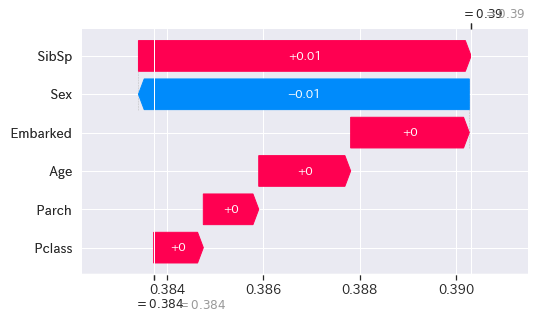

In [200]:
# Waterfall Plot: shap.plots._waterfall.waterfall_legacy() を使うことに注意
# 各予測に対して、どの特徴がどういう寄与をしたかを示す

person_index = 11
shap.plots._waterfall.waterfall_legacy(expected_value=deep_explainer.expected_value[0],
                    shap_values=deep_shap_values[person_index],
                    features=feature_data.iloc[person_index],
                    feature_names=feature_data.columns)

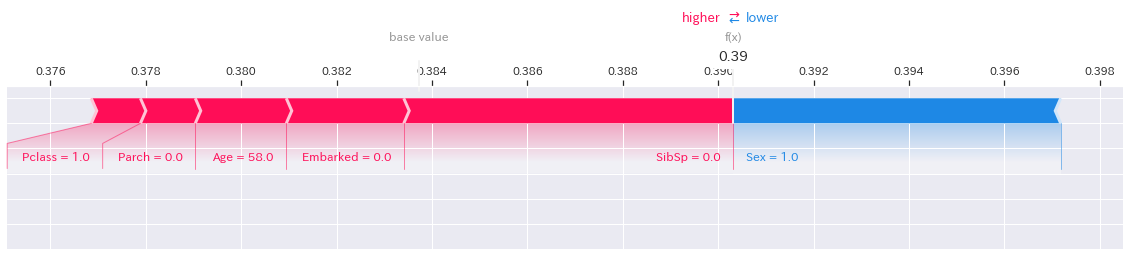

In [201]:
# force plot: waterfallと同様
person_index = 11

shap.force_plot(
    base_value=deep_explainer.expected_value[0], 
    shap_values=deep_shap_values[person_index,:], 
    features=feature_data.iloc[person_index,:],
    matplotlib=True
)